## Introduction
Human Activity Recognition (HAR) using smartphones dataset. Classifying the type of movement amongst six
categories:
1. Walking
2. Walking Upstairs
3. Walking Downstairs
4. Sitting
5. Standing
6. Laying
Compared to a classical approach, using Long Short-Term Memory cells (LSTMs) requires no or almost no feature
engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem
correctly.

## Import the libraries

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.7MB 38kB/s 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', 100)

sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn-whitegrid')

%matplotlib inline

In [77]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

### Data prepration and loading

In [7]:
#@title
from google.colab import drive
drive.mount('/content/gdrive')

! cp /content/gdrive/MyDrive/Colab\ Notebooks/TensorFlow/assignment-2/dataset -r .
! cp /content/gdrive/MyDrive/Colab\ Notebooks/mylib -r .

Mounted at /content/gdrive


#### Load data
The input data is in CSV format where columns are separated by whitespace. Each of these files can be loaded as a NumPy array.


We can then load all data for a given group (train or test) into a single three-dimensional NumPy array, where the dimensions of the array are [samples, time steps, features].

To make this clearer, there are 128 time steps and nine features, where the number of samples is the number of rows in any given raw signal data file.



Helper functions to load data

In [8]:
#@title
# load a single file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values


# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list() # List holding numpy of 2D array
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded) # Convert 2D to 3D array
    return loaded


# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_' + group + '.txt', 'total_acc_y_' + group + '.txt', 'total_acc_z_' + group + '.txt']
    # body acceleration
    filenames += ['body_acc_x_' + group + '.txt', 'body_acc_y_' + group + '.txt', 'body_acc_z_' + group + '.txt']
    # body gyroscope
    filenames += ['body_gyro_x_' + group + '.txt', 'body_gyro_y_' + group + '.txt', 'body_gyro_z_' + group + '.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_' + group + '.txt')

    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix + 'dataset/')
    # load all test
    X_test, y_test = load_dataset_group('test', prefix + 'dataset/')

    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    # one hot encode y
    from keras.utils import to_categorical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Print the shape of Train and Test dataset
    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    print(f"Train data shape {X_train.shape}\nTest data shape {X_test.shape}")
    print(f"Train Y shape {y_train.shape}\nTest y shape {y_test.shape}")

    return X_train, y_train, X_test, y_test


In [9]:
X_train, y_train, X_test, y_test = load_dataset()

Train data shape (7352, 128, 9)
Test data shape (2947, 128, 9)
Train Y shape (7352, 6)
Test y shape (2947, 6)


The three dimensions of this input are:

* Samples. One sequence is one sample. A batch is comprised of one or more samples.
* Time Steps. One time step is one point of observation in the sample.
* Features. One feature is one observation at a time step.

In [11]:
n_samples, n_timesteps, n_features = X_train.shape[0], X_train.shape[1], X_train.shape[2]

input_signals = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Dict to save label index
activity_labels = {
        'WALKING': 0,
        'WALKING_UPSTAIRS': 1,
        'WALKING_DOWNSTAIRS': 2,
        'SITTING': 3,
        'STANDING': 4,
        'LAYING': 5
}

### Visualize data points



Helper methods to plot distribution

In [6]:
#@title
def plot_feature_distributions(X):
  """ Method to plot distribution of each feature variable in the dataset """
  # remove overlap
  cut = int(X.shape[1] / 2)
  longX = X[:, -cut:, :]
  # flatten windows
  longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
  plt.figure()
  fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,9))
  for i in range(3):
    for j in range(3):
      ax = axs[i,j]
      # create histogram
      ax.hist(longX[:, i+j], bins=100, facecolor='#2ecc71', alpha=0.8)
      ax.set_xlim(-1, 1)
      # simplify axis remove clutter
      ax.set_yticks([])
      ax.set_xticks([-1,0,1])
      ax.set_title(input_signals[i+j], loc='center')
  
  # Put space between Sub-Plots
  fig.subplots_adjust(hspace=0.4) 
  _ = plt.show()

def plot_activity_distribution(activities, X=X_train, y=y_train):
  """ Method to plot distribution against Activities """
  for column in activities:
    # get the filtered data
    data = X[np.where((y[:,activity_labels[column]] == 1))][:,0,:]
    df = pd.DataFrame(data=data)

    title = f"{column}- Distribution plot"
    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.stripplot(data=df, jitter=0.2, size=2.5)
    ax = sns.violinplot(data=df)
    ax.set(title=title)
    # ax.set_ylim(-4, 3)
  # Put space between Sub-Plots
  fig.subplots_adjust(hspace=0.4) 
  _ = plt.show()
 

<Figure size 640x480 with 0 Axes>

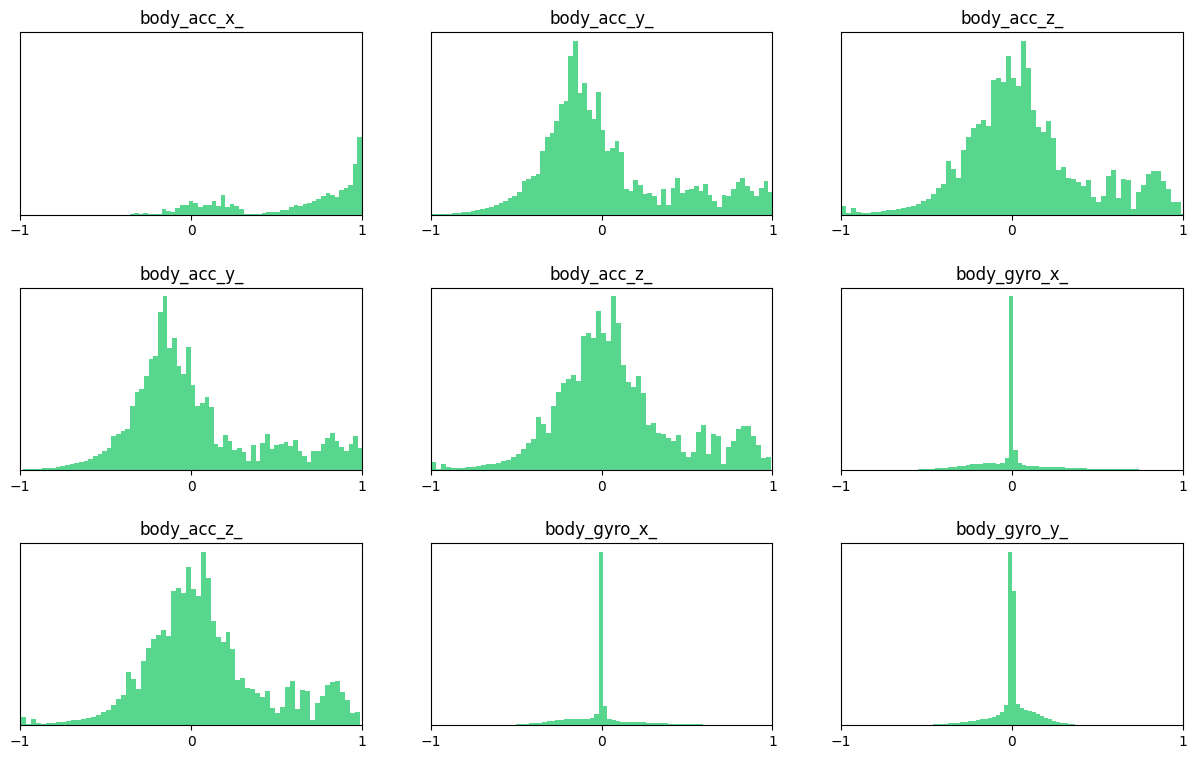

In [7]:
# plot histograms
plot_feature_distributions(X_train)

The data is sufficiently Gaussian-like, except body_acc_x_

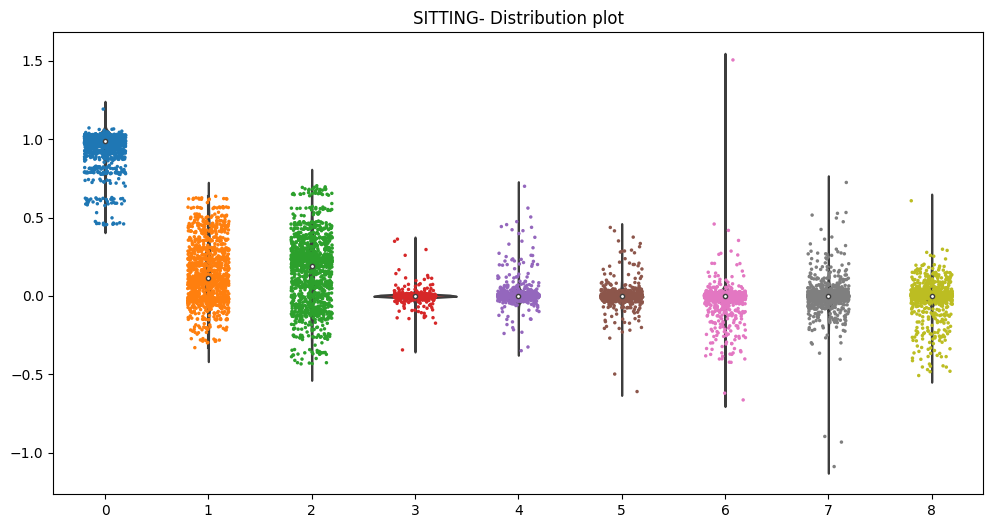

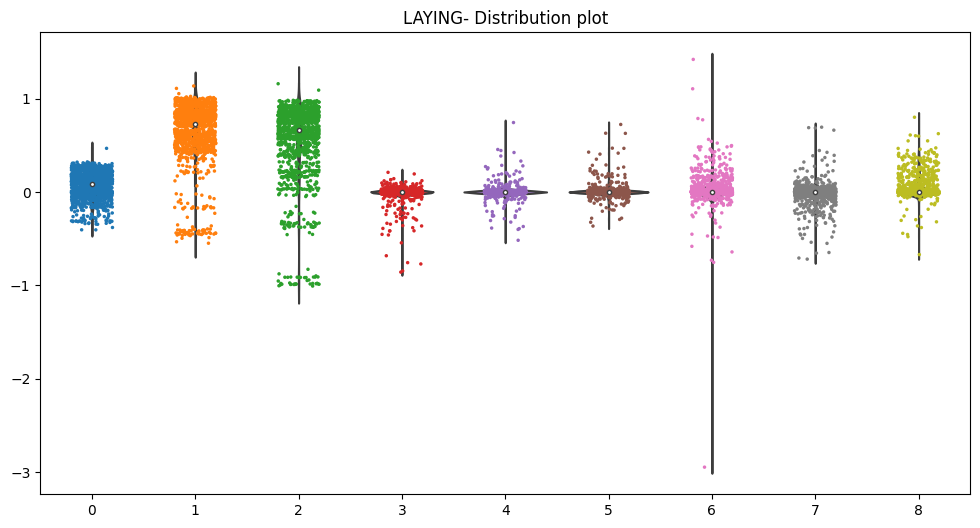

In [8]:
plot_activity_distribution(['SITTING','LAYING'], X_train, y_train)

## Preprocessing
##### Standardize and Normalize the feature data

In [9]:
def normalize_data(X_train, X_test):
  from sklearn.preprocessing import MinMaxScaler, Normalizer
  s = MinMaxScaler()
  n = Normalizer()
  # flatten train and test
  flatTrainX = X_train.reshape((X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
  flatTestX = X_test.reshape((X_test.shape[0] * X_test.shape[1], X_test.shape[2]))
  # Standardize the data
  flatTrainX = s.fit_transform(flatTrainX)
  flatTestX = s.fit_transform(flatTestX)
  # Normalize the data
  flatTrainX = n.fit_transform(flatTrainX)
  flatTestX = n.fit_transform(flatTestX)
  # reshape
  flatTrainX = flatTrainX.reshape((X_train.shape))
  flatTestX = flatTestX.reshape((X_test.shape))
  return flatTrainX, flatTestX


In [10]:
X_train_std, X_test_std = normalize_data(X_train, X_test)

<Figure size 640x480 with 0 Axes>

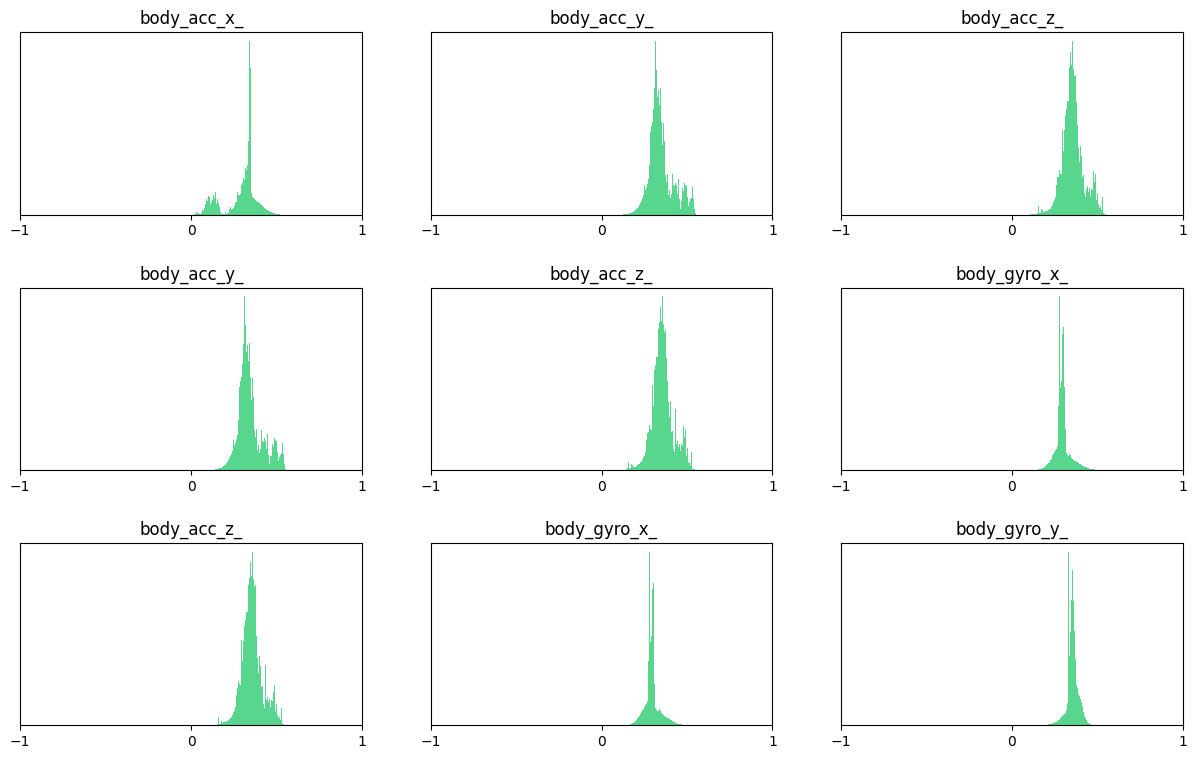

In [11]:
# plot histograms
plot_feature_distributions(X_train_std)

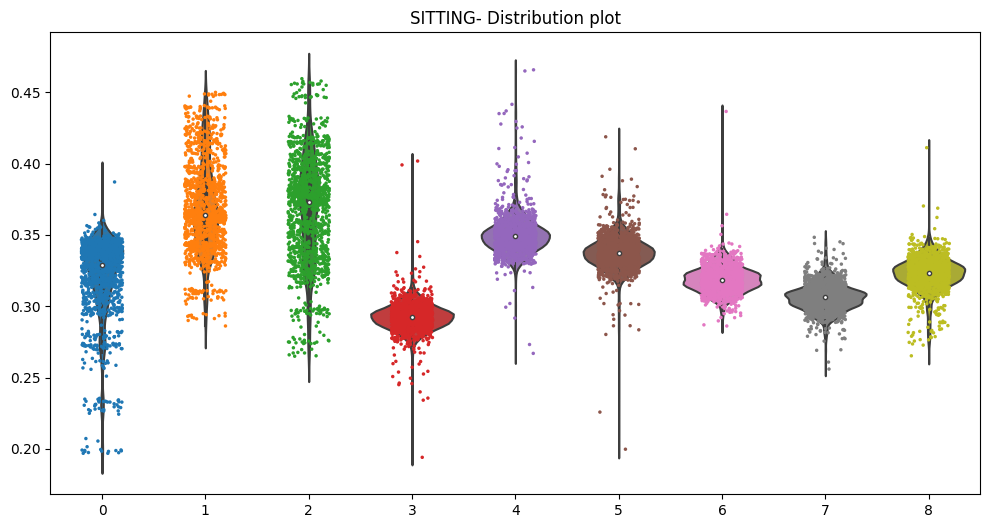

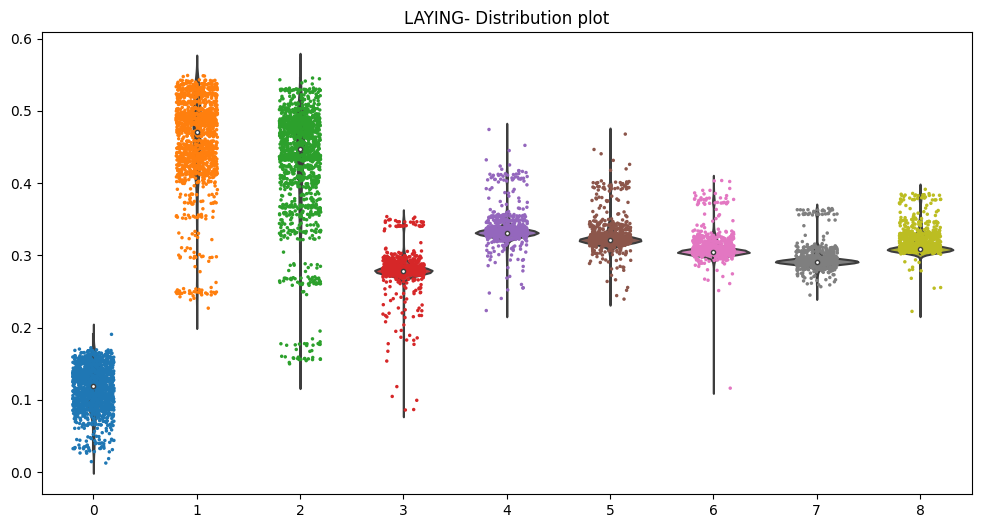

In [12]:
plot_activity_distribution(['SITTING','LAYING'], X_train_std, y_train)

# Build the models, compile and Evaluate

Import libraries

In [23]:
import tensorflow as tf
# from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, Flatten, LSTM, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras.constraints import maxnorm

In [13]:
regularizer = tf.keras.regularizers.l2(0.01)
input_shape, n_outputs  = (n_timesteps, n_features), y_train.shape[1]

# Callbacks
lr_reduce = ReduceLROnPlateau( factor=0.2, 
                               min_delta=0.001, # minimium amount of change to count as an improvement
                               patience=5, # how many epochs to wait before stopping
                              verbose=1)
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
my_callbacks = [lr_reduce, early_stopping]

## Model 1 :LSTM
 
1.   LSTM Layer   
&emsp;&emsp;input_shape : 128 x 9   
&emsp;&emsp;number of units : 90   
&emsp;&emsp;Return Sequence : True - Feed output to next layer with same dimensions as
2.   Dropout - 0.5
3.   LSTM Layer
4.   Dense Layer : number of units : 90   
5.   Dropout - 0.5
6.   Dense Layer for output

In [64]:
tf.keras.backend.clear_session()

In [75]:
def plot_confusion_matrix(cf_matrix_data, target_names,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """    
    from sklearn.metrics import confusion_matrix
    df_cm = pd.DataFrame(cf_matrix_data, columns=target_names, index = target_names).astype('float')
    
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,8))
    plt.title(title, color='green', fontsize=25)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45, color='indigo')
    plt.yticks(tick_marks, target_names, color='indigo')
    sns.set(font_scale=1.4) #for label size
    plt.tight_layout()
    plt.ylabel('Actual', color='crimson', fontsize=20)
    plt.xlabel('Predicted', color='crimson', fontsize=20)
    sns.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 16}, fmt=".0f")
    # plt.imshow(df_cm, interpolation='nearest', cmap="YlGnBu")
    _ = plt.show()

def print_confusion_matrix(model, X_test, y_test, target_names=None, title="Confusion Matrix"):
  """ Method to print and plot Confusion matrix, F1 Score """
  from sklearn.metrics import classification_report, confusion_matrix, f1_score
  y_pred_classes = np.argmax(model.predict(X_test) ,axis = 1) # Multiclass classification
  y_true_classes = np.argmax(y_test, axis=1) # Multiclass classification
  print (classification_report(y_true_classes, y_pred_classes, target_names=target_names))
  plot_confusion_matrix(confusion_matrix(y_true_classes, y_pred_classes), 
                        target_names, title)
  

def plot_loss_acc(history, train_score, test_score, batch_size=None):
  """
  Method to plot the Loss and Accurracy with the given History dataframe as input
  """
  history_df = pd.DataFrame(history.history)
  # train_loss, train_accuracy = train_score[0], train_score[1]
  # test_loss, test_accuracy = test_score[0], test_score[1]
  print("----------------------------------------------------------")
  print("\t          | Train | Test")  
  print("----------------------------------------------------------")
  print(f"\tLoss      | {train_score[0]:.3f} | {test_score[0]:.3f}")  
  print(f"\tAccurracy | {train_score[1]:.3f} | {test_score[1]:.3f}")  
  print("----------------------------------------------------------")
  # plot loss during training
  fig, ax = plt.subplots(ncols=2, figsize=(10,5))
  fig.suptitle(f'Loss and Accurracy Graph\nBatch size {batch_size}', size=15)
  
  ax[0].set_title('Loss')
  ax[0].plot(history_df['loss'], label='train')
  if 'val_loss' in history_df.columns:
    ax[0].plot(history_df['val_loss'], label='test')
  ax[0].legend()
  # plot mse during training
  ax[1].set_title('Accurracy')
  ax[1].plot(history_df['accuracy'], label='train')
  if 'val_accuracy' in history_df.columns:
    ax[1].plot(history_df['val_accuracy'], label='test')
  ax[1].legend()
  plt.show()


def build_lstm_model(X_train, y_train, X_test, y_test, epochs=25, verbose=1, 
                   batch_size=32, n_lstm_units=90, n_dense_units=120,
                   optimizer=Adam(), show_summary=False, plot=True):
  """
  Method to Build, Compile and Train LSTM model. Can also plot the loss and accuracy
  Takes various parameters as input
  """  
  from time import perf_counter
  model = Sequential()
  model.add(LSTM(n_lstm_units, input_shape=(n_timesteps,n_features), 
                 kernel_regularizer=regularizer, kernel_constraint=maxnorm(3),
                 return_sequences=True ))
  model.add(Dropout(0.5))
  model.add(LSTM(n_lstm_units, kernel_regularizer=regularizer))
  model.add(Dense(n_dense_units, activation='relu', kernel_regularizer=regularizer
                  , kernel_constraint=maxnorm(3)))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  if show_summary:
    print(model.summary())
  # fit network
  t_start = perf_counter()
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      verbose=verbose, validation_split=0.1,
                      validation_data=(X_test, y_test), callbacks=my_callbacks)
  # Check time taken
  train_time  = perf_counter() - t_start
  print("\n")
  print(f"Time taken for training : {train_time:0.2f} seconds. Batch size : {batch_size}")

  # evaluate model
  test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
  test_score = (test_loss, test_accuracy)  

  train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
  train_score = (train_loss, train_accuracy)  

  if plot:
    # Plot model evaluation
    plot_loss_acc(history, train_score, test_score, batch_size)

  # Return the metrics
  return model, history, train_score, test_score


Build, Compile, Train and evaluate Model



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 90)           36000     
_________________________________________________________________
dropout (Dropout)            (None, 128, 90)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90)                65160     
_________________________________________________________________
dense (Dense)                (None, 120)               10920     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 726       
Total params: 112,806
Trainable params: 112,806
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
207/207 [==============================] - 39s 173ms/step - loss: 4.3401 - accuracy: 0.3146 - val_lo

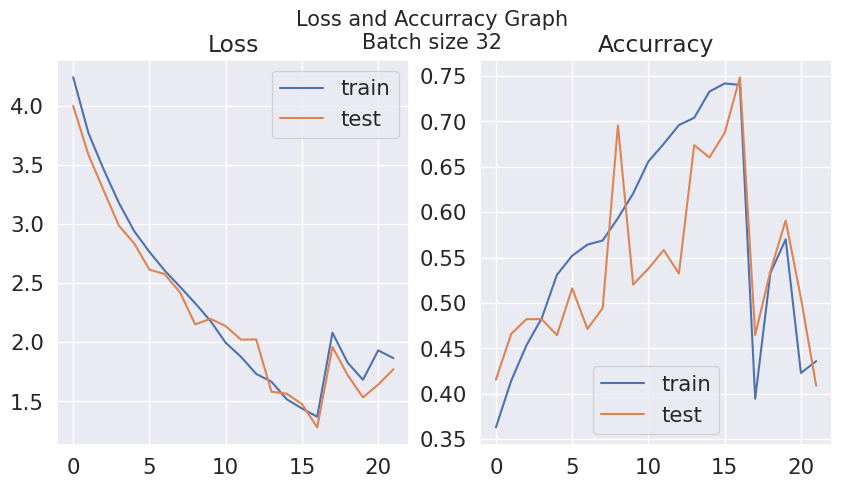

In [65]:
# Excecute the model, show summary and all undergoing operations
model, history, train_score, test_score = build_lstm_model(X_train, y_train, X_test, y_test,
                                                           batch_size=32,verbose=1, show_summary=True,
                                                           optimizer=SGD())

#### We have observed Adam is performing quite well compared to SGD, with Adam accuracy was achieved upto 89.7 %
#### Default Learning rate was used but set to the best using Callback - 0.00199. 

#### Classification Report

                    precision    recall  f1-score   support

           WALKING       0.69      0.88      0.78       496
  WALKING_UPSTAIRS       0.49      0.73      0.58       471
WALKING_DOWNSTAIRS       0.45      0.17      0.24       420
           SITTING       0.92      0.59      0.72       491
          STANDING       0.72      0.85      0.78       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.71      2947
         macro avg       0.71      0.69      0.68      2947
      weighted avg       0.72      0.71      0.70      2947



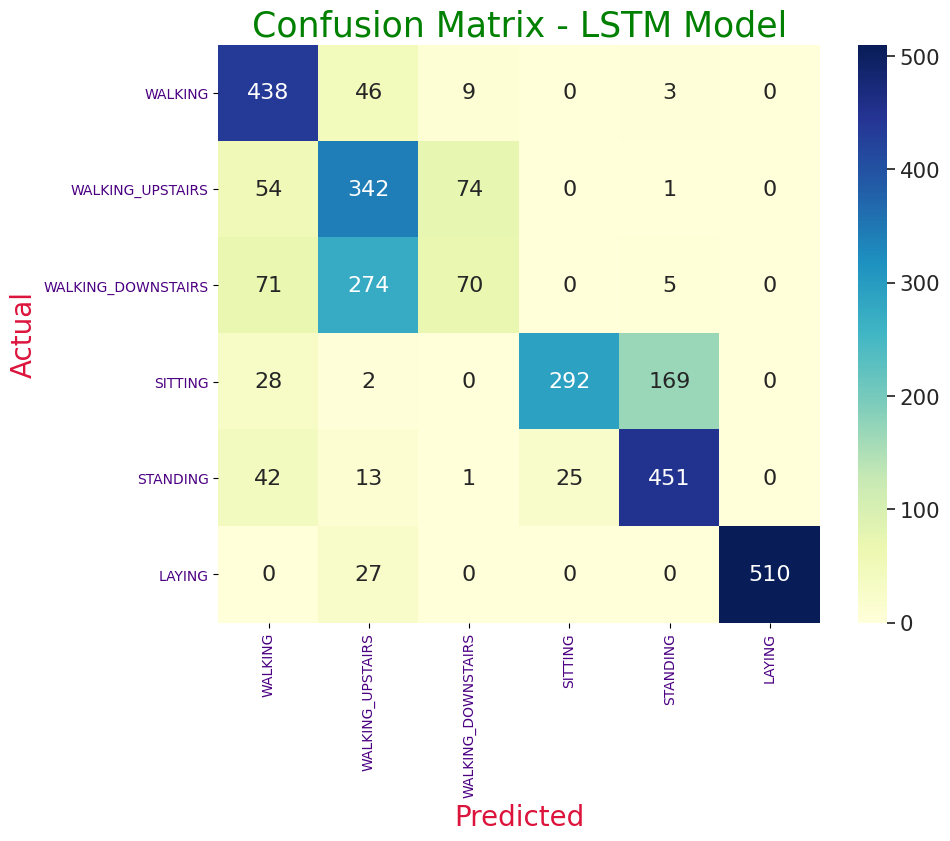

In [78]:
print_confusion_matrix(model, X_test, y_test, target_names=activity_labels, title="Confusion Matrix - LSTM Model")

## Model 2 : CNN + LSTM
The CNN-LSTM architecture involves using Convolutional Neural Network (CNN) layers for
feature extraction on input data combined with LSTMs to support sequence prediction. The CNN-LSTM model will read subsequences of the main sequence in as blocks, extract
features from each block, then allow the LSTM to interpret the features extracted from each
block. One approach to implementing this model is to split each window of 128 time steps into
subsequences for the CNN model to process. For example, the 128 time steps in each window
can be split into four subsequences of 32 time steps.


We can then define a CNN model that expects to read in sequences with a length of 32 time
steps and nine features. The entire CNN model can be wrapped in a TimeDistributed layer
to allow the same CNN model to read in each of the four subsequences in the window. The
extracted features are then flattened and provided to the LSTM model to read, extracting its
own features before a final mapping to an activity is made

1.   LSTM Layer   
&emsp;&emsp;input_shape : 128 x 9   
&emsp;&emsp;number of units : 90   
&emsp;&emsp;Return Sequence : True - Feed output to next layer with same dimensions as
2.   Dropout - 0.5
3.   LSTM Layer
4.   Dense Layer : number of units : 90   
5.   Dropout - 0.5
6.   Dense Layer for output

In [79]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [80]:
X_train.shape, X_test.shape

((7352, 4, 32, 9), (2947, 4, 32, 9))

In [97]:
def build_cnn_lstm_model(X_train, y_train, X_test, y_test, epochs=25, verbose=1, 
                   batch_size=32, n_filters=256, n_lstm_units=90, n_dense_units=120,
                   optimizer=Adam(), show_summary=False, plot=True):
  """
  Method to Build, Compile and Train LSTM model. Can also plot the loss and accuracy
  Takes various parameters as input
  """  
  from time import perf_counter
  model = Sequential()
  model.add(TimeDistributed(
      Conv1D(filters=n_filters, kernel_size=3, activation='relu',
             kernel_regularizer=regularizer, kernel_constraint=maxnorm(3)
             )
      ,input_shape=(None,n_length,n_features)
      ))
  model.add(TimeDistributed(
      Conv1D(filters=n_filters, kernel_size=3, activation='relu',
             kernel_regularizer=regularizer, kernel_constraint=maxnorm(3)
             )
      ))
  model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(MaxPool1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(n_lstm_units, kernel_regularizer=regularizer, 
                 kernel_constraint=maxnorm(3), return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(n_lstm_units))
  model.add(Dense(n_dense_units, activation='relu', kernel_regularizer=regularizer
                  , kernel_constraint=maxnorm(3) ))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  if show_summary:
    print(model.summary())
  
  # fit network
  t_start = perf_counter()
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      verbose=verbose, validation_split=0.1,
                      validation_data=(X_test, y_test), callbacks=my_callbacks)
  # Check time taken
  train_time  = perf_counter() - t_start
  print("\n")
  print(f"Time taken for training : {train_time:0.2f} seconds. Batch size : {batch_size}")
  
  # evaluate model
  test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
  test_score = (test_loss, test_accuracy)  

  train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
  train_score = (train_loss, train_accuracy)  

  if plot:
    # Plot model evaluation
    plot_loss_acc(history, train_score, test_score, batch_size)

  # Return the metrics
  return model, history, train_score, test_score


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, None, 30, 256)     7168      
_________________________________________________________________
time_distributed_31 (TimeDis (None, None, 28, 256)     196864    
_________________________________________________________________
time_distributed_32 (TimeDis (None, None, 28, 256)     0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, None, 14, 256)     0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, None, 3584)        0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 90)          1323000   
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 90)         

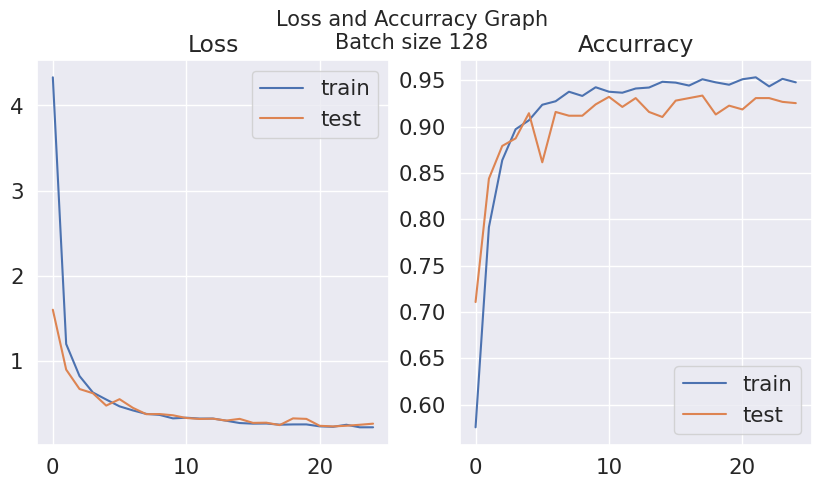

In [98]:
# Excecute the model, show summary and all undergoing operations
model_2, history, train_score, test_score = build_cnn_lstm_model(X_train, y_train, X_test, y_test,
                                                           batch_size=128,verbose=1, show_summary=True,
                                                           optimizer=Adam())

                    precision    recall  f1-score   support

           WALKING       0.99      0.76      0.86       496
  WALKING_UPSTAIRS       0.74      0.90      0.81       471
WALKING_DOWNSTAIRS       0.80      0.93      0.86       420
           SITTING       0.80      0.84      0.82       491
          STANDING       0.89      0.80      0.84       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.86      2947
         macro avg       0.87      0.86      0.86      2947
      weighted avg       0.88      0.86      0.86      2947



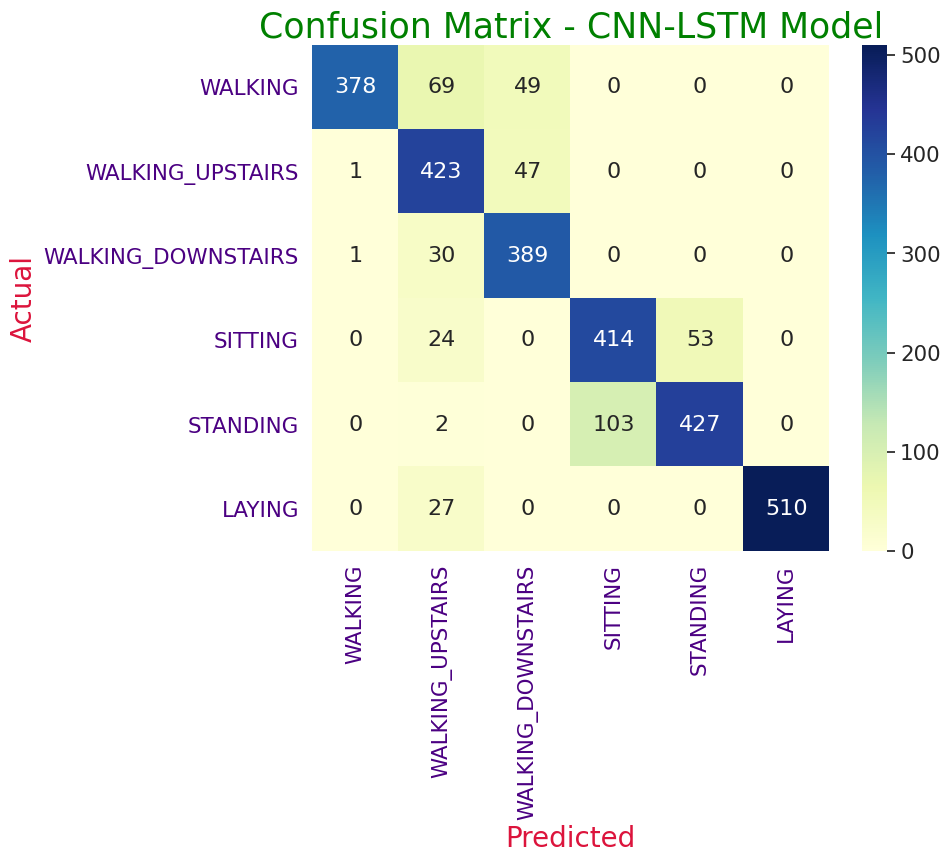

In [101]:
print_confusion_matrix(model_2, X_test, y_test, target_names=activity_labels, title="Confusion Matrix - CNN-LSTM Model")

# Conclusion
We can see an accuracy of 86.3 % is achived with CNN-LSTM has been achived
Standing has been misclassified as Sitting by our model
Further improvement can be achieved by Hyper-Parameter tuning of the Model with more epochs as well